In [23]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

# --- GPT with auxiliary reverse-embedding loss from zb ---
import math, inspect
from dataclasses import dataclass
import torch
from torch import nn
import torch.nn.functional as F

# assumes Block and LayerNorm are defined elsewhere (as in your current setup)

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):

    def __init__(self, config: GPTConfig,
                 aux_scale: float = 1.0,
                 noise_constituent: float = 1e-4,
                 noise_final: float = 1e-4):
        super().__init__()
        assert config.vocab_size is not None and config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        # per-block orthonormal maps for blocks 0..3
        need_blocks = 4
        if config.n_layer < need_blocks:
            raise ValueError(f"need at least {need_blocks} transformer blocks for aux; got {config.n_layer}")
        self.aux_blocks = list(range(need_blocks))  # [0,1,2,3] fixed
        self.aux_maps = nn.ModuleList()
        for _ in self.aux_blocks:
            lin = nn.Linear(config.n_embd, config.n_embd, bias=False)
            nn.init.orthogonal_(lin.weight)  # square => orthonormal rows & columns
            self.aux_maps.append(lin)

        # noise/scales
        self.aux_scale_default = float(aux_scale)
        self.noise_constituent = float(noise_constituent)
        self.noise_final = float(noise_final)

        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # reverse-embedding for one lane (list length T of [idxs, probs])
    def _rev_embed_lane(self, lane_seq, device):
        T = len(lane_seq)
        if T == 0:
            return torch.empty(0, self.config.n_embd, device=device)
        idxs = torch.tensor([pair[0] for pair in lane_seq], device=device, dtype=torch.long)      # (T, K)
        probs = torch.tensor([pair[1] for pair in lane_seq], device=device, dtype=torch.float32)  # (T, K)
        probs = probs / (probs.sum(dim=-1, keepdim=True) + 1e-12)

        E = self.transformer.wte.weight  # (V, D)
        emb = E.index_select(0, idxs.reshape(-1)).reshape(*idxs.shape, E.size(1))  # (T, K, D)
        if self.noise_constituent > 0:
            emb = emb + torch.randn_like(emb) * self.noise_constituent
        rev = torch.einsum('tkd,tk->td', emb, probs)  # (T, D)
        if self.noise_final > 0:
            rev = rev + torch.randn_like(rev) * self.noise_final
        return rev

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 66
    n_layer: int = 4          # explicitly 4 per your instruction
    n_head: int = 8
    n_embd: int = 128
    dropout: float = 0.0
    bias: bool = True


    # -------- reverse-embedding helpers (batchified, same dtype/device as x) --------
def soft_ce(logits: torch.Tensor, target_probs: torch.Tensor, ignore_mask =None):
        """
        logits: (B, T, V)
        target_probs: (B, T, V) row-normalized
        ignore_mask: (B, T) bool, True where we KEEP, False to ignore
        """
        logp = F.log_softmax(logits, dim=-1)
        loss = -(target_probs * logp).sum(dim=-1)  # (B, T)
        if ignore_mask is not None:
            loss = loss * ignore_mask
            denom = torch.clamp(ignore_mask.sum(), min=1)
            return loss.sum() / denom
        else:
            return loss.mean()

def sharpen_distribution(idx: torch.Tensor, p: torch.Tensor, V: int, alpha: float) -> torch.Tensor:
        """
        idx: (B, T, K) long
        p:   (B, T, K) float
        return dense (B, T, V) probs with sharpening exponent alpha (alpha>1 => more peaked)
        """
        B, T, K = idx.shape
        out = torch.full((B, T, V), 0.0, dtype=p.dtype, device=p.device)
        # apply exponent (temperature-like). alpha==1 means unchanged
        q = torch.clamp(p, min=1e-12) ** alpha
        q = q / q.sum(dim=-1, keepdim=True)
        out.scatter_add_(dim=-1, index=idx, src=q)
        return out

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

class StochasticEmbedding(nn.Embedding):
    """
    A swap-in replacement for nn.Embedding that sometimes "smudges" inputs by
    replacing a hard index lookup with a small weighted mixture over up to K tokens.

    Key behavior:
    - With probability `mix_prob` (per position), use a mixture; otherwise do a standard idx->embedding.
    - The mixture *always* includes the original idx and keeps it as the most likely token.
    - The remaining mixture members (up to `max_blend`) are:
        * If Z is provided: taken from the previous position's Z-index candidates, with randomized sharpening.
        * Else: random distinct tokens (excluding idx).
    - Weights are *uneven* and decay gradually (geometric), then normalized.
    - Position t=0 is always pure (hard idx).
    - During eval mode, mixing is disabled by default (can be enabled with `enable_in_eval=True`).

    Expected Z format (optional):
        z_prev = (Z_idx, Z_p)
        shapes: Z_idx: (B, T, Kz), Z_p: (B, T, Kz)
        For input at time t, we *key* into Z at t-1 (previous position).
        If Z is provided for the whole sequence, you can pass it directly and this layer
        will handle the t-1 alignment internally.

    Args:
        num_embeddings: vocab size
        embedding_dim:  embedding size
        mix_prob:       probability to use a mixture at a given (b, t) position
        max_blend:      up to this many *additional* indices beyond `idx` (<=16 as requested)
        alpha_range:    (low, high) range for random sharpening exponent applied to Z probs
        geom_decay_range: range for random geometric ratio r in (low, high) to create uneven, decaying weights
        ensure_idx_top_margin: multiplicative margin to ensure idx remains strictly the top prob
        enable_in_eval: if True, still perform mixing during model.eval(); else mixing only in training
    """

    def __init__(
        self,
        num_embeddings: int,
        embedding_dim: int,
        mix_prob: float = 0.3,
        max_blend: int = 16,
        alpha_range: Tuple[float, float] = (0.8, 2.0),
        geom_decay_range: Tuple[float, float] = (0.55, 0.9),
        ensure_idx_top_margin: float = 1.05,
        enable_in_eval: bool = False,
        **kwargs,
    ):
        super().__init__(num_embeddings, embedding_dim, **kwargs)
        if max_blend < 0 or max_blend > 16:
            raise ValueError("max_blend must be in [0, 16].")
        self.mix_prob = float(mix_prob)
        self.max_blend = int(max_blend)
        self.alpha_range = alpha_range
        self.geom_decay_range = geom_decay_range
        self.ensure_idx_top_margin = float(ensure_idx_top_margin)
        self.enable_in_eval = bool(enable_in_eval)

    @torch.no_grad()
    def _rand_geom_weights(self, k: int, device: torch.device, dtype: torch.dtype) -> torch.Tensor:
        """
        Create a strictly decreasing, uneven weight vector of length k via a random geometric ratio.
        Returns a normalized vector (sums to 1).
        """
        r = torch.empty(1, device=device, dtype=dtype).uniform_(*self.geom_decay_range).item()  # scalar ratio
        # weights ~ [1, r, r^2, ...]
        exps = torch.arange(k, device=device, dtype=dtype)
        w = torch.pow(torch.tensor(r, device=device, dtype=dtype), exps)
        w = w / (w.sum() + 1e-12)
        return w

    @torch.no_grad()
    def _apply_sharpening(self, probs: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Sharpen/widen probabilities: q_i ∝ p_i^alpha. alpha>1 => more peaked, alpha<1 => flatter.
        """
        q = torch.clamp(probs, min=1e-12) ** alpha
        q = q / (q.sum() + 1e-12)
        return q

    def forward(
        self,
        idx: torch.Tensor,
        z_prev: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # (Z_idx, Z_p), each (B,T,Kz)
    ) -> torch.Tensor:
        """
        idx: (B, T) Long
        z_prev: optional tuple (Z_idx, Z_p), both shaped (B, T, Kz).
                For current position t, we look at z_prev[:, t-1] (previous position).
        Returns:
            embeddings: (B, T, D)
        """
        if idx.dtype != torch.long:
            raise TypeError("idx must be torch.long")

        B, T = idx.shape
        device = idx.device
        D = self.embedding_dim
        E = self.weight  # (V, D)

        # Early exit if mixing disabled (e.g., eval mode and not enabled)
        mixing_active = self.training or self.enable_in_eval
        if not mixing_active or self.mix_prob <= 0.0 or self.max_blend == 0:
            # Just standard embedding, except we always keep t=0 pure anyway (same outcome here).
            return super().forward(idx)

        # We will construct output one position group at a time for clarity.
        out = torch.empty(B, T, D, device=device, dtype=E.dtype)

        # Sample where to mix (Bernoulli per token position), but force t==0 to False.
        mix_mask = torch.rand(B, T, device=device) < self.mix_prob
        if T > 0:
            mix_mask[:, 0] = False  # first element always x (pure)
        if model.training == False:
            mix_mask[:,:]= False#always pure when eval

        # Helper to do a pure lookup fast:
        if (~mix_mask).any():
            out[~mix_mask] = E[idx[~mix_mask]]

        # If we have no positions to mix, we are done.
        if not mix_mask.any():
            return out

        # If Z is provided, we will use previous position (t-1) candidates to key the mixture.
        have_z = z_prev is not None
        if have_z:
            Z_idx, Z_p = z_prev
            assert Z_idx.shape[:2] == (B, T) and Z_p.shape[:2] == (B, T), "Z shapes must be (B,T, Kz)"
            assert Z_idx.shape == Z_p.shape, "Z_idx and Z_p must have identical shapes"
            # We'll access Z at t-1 for each position t; t=0 is never mixed per mask anyway.

        # Process mixing positions, possibly in a light loop (readability > micro-optimizations)
        mix_positions = mix_mask.nonzero(as_tuple=False)  # list of (b, t) rows
        V = E.size(0)

        for b, t in mix_positions.tolist():
            cur_idx = idx[b, t].item()

            # Build candidate set: always include cur_idx first
            cand = [cur_idx]
            cand_weights = None  # will be set later (unnormalized)

            if have_z and t > 0:
                # Use Z keyed from previous position
                z_i = Z_idx[b, t - 1]  # (Kz,)
                z_p = Z_p[b, t - 1]    # (Kz,)

                # Randomly sharpen/widen Z
                alpha = float(torch.empty(1, device=device).uniform_(*self.alpha_range).item())
                z_q = self._apply_sharpening(z_p.to(torch.float32), alpha)  # (Kz,)

                # Take top candidates from z (excluding cur_idx), up to max_blend
                # We'll sort by z_q descending to preserve a "gradual reduction" feel.
                top_vals, top_idx = torch.topk(z_q, k=min(self.max_blend + 4, z_q.numel()))  # oversample a bit
                z_cands = []
                for j in top_idx.tolist():
                    tok = int(z_i[j].item())
                    if tok != cur_idx and tok not in z_cands:
                        z_cands.append(tok)
                        if len(z_cands) >= self.max_blend:
                            break

                # If Z didn't yield enough distincts (rare), fill randomly
                need = self.max_blend - len(z_cands)
                if need > 0:
                    # sample without replacement, excluding cur_idx and z_cands
                    exclude = set([cur_idx] + z_cands)
                    # Draw a bit more than needed and filter
                    rand_pool = torch.randperm(V, device=device)[: max(need * 4, need + 8)].tolist()
                    for tok in rand_pool:
                        if tok not in exclude:
                            z_cands.append(tok)
                            exclude.add(tok)
                            if len(z_cands) >= self.max_blend:
                                break

                cand.extend(z_cands)

                # Create uneven, decaying weights aligned with sorted z_q order
                # Start from geometric decay, then bias by z_q ranks a bit
                k_total = len(cand)
                geom_w = self._rand_geom_weights(k_total, device=device, dtype=torch.float32)

                # Modulate the tail (excluding idx at position 0) by the (sorted) z_q values we used
                # to keep a Z-keyed shape. Map z_cands in the order we picked them (already roughly top->down).
                tail = geom_w[1:].clone()
                if len(z_cands) > 0:
                    # z shape weights based on normalized top_vals (already top->down)
                    zshape = top_vals[: len(z_cands)].to(torch.float32)
                    zshape = zshape / (zshape.sum() + 1e-12)
                    # mix geometric decay with zshape to keep unevenness and Z-key
                    tail = 0.5 * tail + 0.5 * (zshape * tail.sum())  # keep total tail mass

                # Reassemble, ensure idx (slot 0) is strongest
                cand_weights = torch.cat([geom_w[0:1], tail], dim=0)

            else:
                # No Z available (or t==0, but t==0 never mixes). Fall back to random candidates with decaying weights.
                # Sample distinct random tokens excluding cur_idx
                need = self.max_blend
                exclude = {cur_idx}
                rand_cands = []
                # Draw a bit more than needed for uniqueness
                for tok in torch.randperm(V, device=device)[: max(need * 4, need + 8)].tolist():
                    if tok not in exclude:
                        rand_cands.append(tok)
                        exclude.add(tok)
                        if len(rand_cands) >= need:
                            break
                cand.extend(rand_cands)
                # Geometric decay weights (uneven)
                cand_weights = self._rand_geom_weights(len(cand), device=device, dtype=torch.float32)

            # Make sure the first element (the true idx) has the HIGHEST probability
            # by granting it a small multiplicative margin, then renormalize.
            cand_weights = cand_weights.clone()
            cand_weights[0] = cand_weights[0] * self.ensure_idx_top_margin
            cand_weights = cand_weights / (cand_weights.sum() + 1e-12)

            # Turn the mixture into an embedding: sum_j p_j * E[cand_j]
            cand_t = torch.tensor(cand, device=device, dtype=torch.long)
            vecs = E.index_select(0, cand_t)           # (k, D)
            probs = cand_weights.view(-1, 1).to(vecs)  # (k, 1)
            mixed = (vecs * probs).sum(dim=0)          # (D,)
            out[b, t] = mixed

        return out



class GPT(nn.Module):
    def __init__(self, config: GPTConfig,
                 aux_scale: float = 1.0,           # (12) fixed
                 noise_constituent: float = 1e-6,    # (7) fixed
                 noise_final: float = 1e-4):         # (7) fixed
        super().__init__()
        assert config.vocab_size is not None and config.block_size is not None

        self.config = config
        self.aux_scale = float(aux_scale)
        self.noise_constituent = float(noise_constituent)
        self.noise_final = float(noise_final)

        # core transformer
        self.transformer = nn.ModuleDict(dict(
            wte = StochasticEmbedding(
            config.vocab_size, config.n_embd,
            mix_prob=0.3,          # tune
            max_blend=16,          # per your cap
            alpha_range=(0.8, 2.0) # gentle->sharp randomization
        ),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        #self.transformer.wte.weight = self.lm_head.weight  # weight tying

        # per-block orthonormal linears (square D×D, columns orthonormal)
        self.aux_maps = nn.ModuleList()
        for _ in range(4):
            lin = nn.Linear(config.n_embd, config.n_embd, bias=False)
            nn.init.orthogonal_(lin.weight)
            self.aux_maps.append(lin)

        # init weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    # --- Patch your GPT class: replace forward with the following ---
    def forward(self, idx, targets=None, zb=None,
                               aux_scale: float = 1.0,
                               depth_alphas  = None,
                               warmup_ignores  = None):
        """
        idx: (B, T) Long
        targets: (B, T) Long or None
        zb: tuple (Z_idx, Z_p) each (B, T, K); single Z shared across blocks
        depth_alphas: per-block sharpening exponents (len == n_layer). e.g. [0.8, 1.0, 1.5, 2.0, ...]
                      alpha<1 widens early, >1 sharpens later — approximates your 'gaussian→peaked student-t'
        warmup_ignores: per-block number of initial positions to ignore for aux
        """
        device = idx.device
        B, T = idx.size()
        assert T <= self.config.block_size
    
        # embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=device)
        tok_emb = self.transformer.wte(idx, z_prev=zb)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
    
        # defaults
        L = len(self.transformer.h)
        if depth_alphas is None:
            # gentle → sharp
            depth_alphas = [0.8 + 1.2 * (i/(L-1)) for i in range(L)] if L > 1 else [1.0]
        if warmup_ignores is None:
            # ignore more in shallow blocks
            warmup_ignores = [min(2**i - 1, T-1) for i in range(L)]  # 0,1,3,7,... capped
    
        # unpack Z
        Z_idx, Z_p = zb if zb is not None else (None, None)
    
        aux_loss = None
        for bidx, block in enumerate(self.transformer.h):
            x = block(x)  # (B, T, D)
            if Z_idx is not None and Z_p is not None:
                V = self.lm_head.out_features
                logits_b = self.lm_head(self.transformer.ln_f(x))  # (B, T, V)
    
                # per-depth skew of the SAME base Z
                Z_dense = sharpen_distribution(Z_idx, Z_p, V, alpha=float(depth_alphas[bidx]))
    
                # warmup ignore mask (keep positions >= ignore)
                keep = torch.arange(T, device=device).expand(B, T) >= int(warmup_ignores[bidx])
                keep = keep.to(logits_b.dtype)
                aux_b = soft_ce(logits_b, Z_dense, ignore_mask=(keep>0))
                aux_loss = aux_b if aux_loss is None else aux_loss + aux_b
    
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
    
        ce_loss = None
        if targets is not None:
            ce_loss = F.cross_entropy(logits.view(-1, logits.size(-1)),
                                      targets.view(-1), ignore_index=-100)
    
        total = None
        if ce_loss is None and aux_loss is None:
            total = None
        elif aux_loss is None:
            total = ce_loss
        elif ce_loss is None:
            total = aux_scale * aux_loss
        else:
            total = ce_loss + aux_scale * aux_loss
    
        if targets is None:
            logits = logits[:, [-1], :]
    
        return logits, total


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [14]:

import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

import os
import pickle
import numpy as np
from collections import defaultdict, Counter
import random

import os
import pickle
import numpy as np
from collections import defaultdict, Counter
from typing import Dict, Tuple, List, Optional

data_dir = "./babylm_char_tokenized"
train_path = os.path.join(data_dir, "train.bin")
val_path   = os.path.join(data_dir, "val.bin")
meta_path  = os.path.join(data_dir, "meta.pkl")
train_ids = np.fromfile(train_path, dtype=np.uint16)
val_ids   = np.fromfile(val_path,   dtype=np.uint16)

with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
vocab_size = meta["vocab_size"]

def global_freqs(ids: np.ndarray, V: int) -> np.ndarray:
    cnt = np.bincount(ids.astype(np.int64), minlength=V)
    # normalize to probability (avoid zero)
    p = cnt.astype(np.float64)
    p = p / max(1.0, p.sum())
    return p
print(f"Loaded {len(train_ids)} train tokens and {len(val_ids)} val tokens | vocab={vocab_size}")
p_global = global_freqs(train_ids, vocab_size)  # used for disciplined fill only

def build_markov_chain(data: np.ndarray, window: int) -> Dict[Tuple[int, ...], Counter]:
    chain = defaultdict(Counter)
    for i in range(len(data) - window):
        ctx = tuple(map(int, data[i:i+window]))
        nxt = int(data[i+window])
        chain[ctx][nxt] += 1
    return chain

ngram_orders = [2,4,8,16,32,64]
markov_models: Dict[int, Dict[Tuple[int,...], Counter]] = {}
for w in ngram_orders:
    print(f"Building order-{w} Markov...")
    markov_models[w] = build_markov_chain(train_ids, w)

def build_bigram_db(data: np.ndarray, V: int, top_k=16, epsilon=1e-6, seed=1337):
    rng = np.random.default_rng(seed)
    counts = np.zeros((V, V), dtype=np.int64)
    a = data[:-1].astype(np.int64)
    b = data[1:].astype(np.int64)
    np.add.at(counts, (a, b), 1)
    out = {}
    all_ids = np.arange(V, dtype=np.int64)
    for t in range(V):
        row = counts[t]
        tot = row.sum()
        if tot == 0:
            idx = rng.choice(V, size=top_k, replace=False)
            p = np.full(top_k, 1.0/top_k, dtype=np.float32)
        else:
            pr = row.astype(np.float64) / float(tot)
            obs = np.flatnonzero(row)
            if len(obs) >= top_k:
                sel = np.argpartition(pr[obs], -top_k)[-top_k:]
                idx = obs[sel]
                p = pr[idx].astype(np.float32)
                s = p.sum()
                p = p/s if s > 0 else np.full(top_k, 1.0/top_k, dtype=np.float32)
            else:
                need = top_k - len(obs)
                mask = np.ones(V, dtype=bool); mask[obs] = False
                extra = np.random.default_rng(seed+t).choice(np.nonzero(mask)[0], size=need, replace=False)
                idx = np.concatenate([obs, extra])
                p   = pr[idx].astype(np.float32)
                # give epsilon to never-seen extras
                unseen = (row[idx] == 0)
                if unseen.any():
                    p = p + unseen.astype(np.float32) * epsilon
                p = p / p.sum()
        order = np.argsort(-p)
        out[t] = (idx[order].astype(np.int64), p[order])
    return out

print("Building bigram db...")
bigram_db = build_bigram_db(train_ids, vocab_size, top_k=64)  # collect a bit wider; we'll cap later

# === Save ===
model_dir = "./markov_bigram_models"
os.makedirs(model_dir, exist_ok=True)

with open(os.path.join(model_dir, "markov_models.pkl"), "wb") as f:
    pickle.dump(markov_models, f)

with open(os.path.join(model_dir, "bigram_db.pkl"), "wb") as f:
    pickle.dump(bigram_db, f)


print("✅ Markov and Bigram models saved.")


✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66
Loaded 1016242 train tokens and 99152 val tokens | vocab=66
Building order-2 Markov...
Building order-4 Markov...
Building order-8 Markov...
Building order-16 Markov...
Building order-32 Markov...
Building order-64 Markov...
Building bigram db...
✅ Markov and Bigram models saved.


In [15]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Replacement dataloader that uses SAVED bigram + markov models and yields (X, Y, Z) ===
import os, pickle, numpy as np, torch
from torch.utils.data import Dataset, DataLoader

# expects `vocab_size` and `device` already defined in the outer scope
# expects saved models at ./markov_bigram_models/{bigram_db.pkl, markov_models.pkl}

class DisciplinedZ:
    def __init__(self, markov_models: Dict[int, Dict[Tuple[int,...], Counter]],
                 bigram_db: Dict[int, Tuple[np.ndarray, np.ndarray]],
                 p_global: np.ndarray,
                 vocab_size: int,
                 top_k: int = 32,
                 epsilon: float = 1e-6):
        self.models = markov_models
        self.bigram_db = bigram_db
        self.p_global = p_global.astype(np.float64)
        self.V = vocab_size
        self.K = top_k
        self.eps = float(epsilon)
        # global sort for fill
        self.global_order = np.argsort(-self.p_global)

    def _cands_from_counter(self, ctr: Optional[Counter]) -> Optional[np.ndarray]:
        if not ctr:
            return None
        return np.fromiter((int(t) for t,_ in ctr.items()), dtype=np.int64)

    def _probs_from_counter(self, ctr: Optional[Counter]) -> Optional[Dict[int, float]]:
        if not ctr:
            return None
        tot = sum(ctr.values())
        if tot == 0:
            return None
        return {int(t): c/tot for t, c in ctr.items()}

    def _bigram_top(self, tok: int, limit: int) -> np.ndarray:
        idx, prob = self.bigram_db.get(int(tok), (None, None))
        if idx is None:
            return np.array([], dtype=np.int64)
        return idx[:limit]

    def _btree_candidates(self, contexts: Dict[int, Tuple[Tuple[int,...], Optional[Counter]]], backoff_tok: int) -> np.ndarray:
        # collect candidate sets from each available context
        sets = []
        for n, (_, ctr) in contexts.items():
            c = self._cands_from_counter(ctr)
            if c is not None and c.size > 0:
                sets.append(set(c.tolist()))
        if len(sets) == 0:
            # no ctx → use bigram set as starting point
            return self._bigram_top(backoff_tok, self.K)

        # try full intersection; if empty, progressively intersect strongest contexts first
        inter = set.intersection(*sets) if len(sets) > 1 else sets[0]
        if len(inter) == 0:
            # heuristic: sort by context order (longest first), intersect greedily
            sets_sorted = sorted(sets, key=lambda s: -len(s))
            inter = sets_sorted[0].copy()
            for s in sets_sorted[1:]:
                new_inter = inter.intersection(s)
                if len(new_inter) > 0:
                    inter = new_inter
        if len(inter) == 0:
            # last resort: union (still disciplined; no random injection)
            union = set()
            for s in sets:
                union |= s
            inter = union

        arr = np.fromiter(inter, dtype=np.int64)
        if arr.size == 0:
            return self._bigram_top(backoff_tok, self.K)
        return arr

    def _score_candidates(self, cands: np.ndarray, contexts: Dict[int, Tuple[Tuple[int,...], Optional[Counter]]]) -> np.ndarray:
        # score = sum over contexts of presence * local prob
        # local prob from per-context normalized counts
        scores = np.zeros(cands.size, dtype=np.float64)
        idxmap = {int(t): i for i, t in enumerate(cands)}
        for n, (_, ctr) in contexts.items():
            probs = self._probs_from_counter(ctr)
            if probs is None:
                continue
            for t, p in probs.items():
                if t in idxmap:
                    scores[idxmap[t]] += float(p)
        # tiny floor to avoid zeros
        scores = scores + (scores == 0) * self.eps
        return scores

    def build_Z_for_sequence(self, seq: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        seq: array of length L = block_size (+optional pad)
        returns:
          topk_idx: (L, K) int64
          topk_p:   (L, K) float32  (row-normalized)
        """
        L = len(seq)
        topk_idx = np.zeros((L, self.K), dtype=np.int64)
        topk_p   = np.zeros((L, self.K), dtype=np.float32)
        for j in range(L):
            back_tok = int(seq[j])
            # collect contexts
            contexts = {}
            for n in ngram_orders:
                if j - (n-1) < 0:
                    continue
                ctx = tuple(int(x) for x in seq[j-(n-1):j+1])
                ctr = self.models[n].get(ctx, None)
                contexts[n] = (ctx, ctr)

            # disciplined candidate set
            cands = self._btree_candidates(contexts, back_tok)

            # cap K by candidate count
            if cands.size >= self.K:
                # score & take best K
                scores = self._score_candidates(cands, contexts)
                order = np.argsort(-scores)[:self.K]
                idx = cands[order]
                sc  = scores[order]
            else:
                # we must fill with globally-most-common tokens (no randoms), excluding existing
                scores = self._score_candidates(cands, contexts) if cands.size > 0 else np.array([], dtype=np.float64)
                missing = self.K - cands.size
                mask = np.ones(vocab_size, dtype=bool)
                mask[cands] = False
                fill = []
                for t in self.global_order:
                    if mask[t]:
                        fill.append(int(t))
                        if len(fill) == missing:
                            break
                if cands.size == 0:
                    idx = np.array(fill, dtype=np.int64)
                    sc  = np.full(len(fill), self.eps, dtype=np.float64)
                else:
                    idx = np.concatenate([cands, np.array(fill, dtype=np.int64)])
                    sc  = np.concatenate([scores, np.full(missing, self.eps, dtype=np.float64)])

            # normalize to prob
            p = sc.astype(np.float64)
            p = p / p.sum() if p.sum() > 0 else np.full_like(p, 1.0/len(p))
            topk_idx[j, :] = idx
            topk_p[j, :]   = p.astype(np.float32)
        return topk_idx, topk_p

discZ = DisciplinedZ(markov_models, bigram_db, p_global, vocab_size, top_k=32, epsilon=1e-6)

import torch
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

class GPUDataset(Dataset):
    def __init__(self, mmap_file, block_size: int, batch_size: int, builder: DisciplinedZ, pad_len:int=0, jitter:int=63, p_aligned:float=0.5, seed:int=1337):
        self.data = mmap_file
        self.block_size = int(block_size)
        self.batch_size = int(batch_size)
        self.pad_len    = int(pad_len)
        self.sample_len = self.block_size + self.pad_len
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = max(1, self.total // self.sample_len)
        self.jitter = int(jitter)
        self.p_aligned = float(p_aligned)
        self.rng = np.random.default_rng(seed)
        self.builder = builder

    def __len__(self):
        return self.total // self.batch_size

    def _sample_block(self):
        base_block = self.rng.integers(0, self.n_blocks)
        start = base_block * self.sample_len
        if self.rng.random() > self.p_aligned:
            j = self.rng.integers(0, self.jitter + 1)
            start = min(start + j, self.total)
        return start

    def __getitem__(self, _):
        B, T = self.batch_size, self.block_size
        X = np.empty((B, self.sample_len), dtype=np.int64)
        Y = np.empty((B, T), dtype=np.int64)
        Z_idx = np.empty((B, T, self.builder.K), dtype=np.int64)
        Z_p   = np.empty((B, T, self.builder.K), dtype=np.float32)
        for i in range(B):
            start = self._sample_block()
            xseq = self.data[start : start + self.sample_len].astype(np.int64)
            yseq = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + T].astype(np.int64)
            X[i] = xseq
            Y[i] = yseq
            idxs, probs = self.builder.build_Z_for_sequence(xseq[:T])
            Z_idx[i] = idxs
            Z_p[i]   = probs
        # torch tensors
        X = torch.from_numpy(X[:, :T]).to(device)
        Y = torch.from_numpy(Y).to(device)
        Z_idx = torch.from_numpy(Z_idx).to(device)
        Z_p   = torch.from_numpy(Z_p).to(device)
        return X, Y, (Z_idx, Z_p)

def collate_identity(batch):
    Xs, Ys, Zs = zip(*batch)
    X = torch.cat(Xs, dim=0)
    Y = torch.cat(Ys, dim=0)
    Zi = torch.cat([z[0] for z in Zs], dim=0)
    Zp = torch.cat([z[1] for z in Zs], dim=0)
    return X, Y, (Zi, Zp)

block_size = 1024
batch_size = 8

GPU_DATASET = GPUDataset(
    np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r'),
    block_size=block_size,
    batch_size=batch_size,
    builder=discZ,
)

train_loader = DataLoader(
    GPU_DATASET,
    batch_size=1,            # keep outer loader at 1; inner dataset batches on GPU
    shuffle=False,
    num_workers=0,
    collate_fn=collate_identity
)
    

In [24]:

import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

config =  GPTConfig(
    block_size,
    vocab_size,
    n_layer=8,      
    n_head = 8,
    n_embd =128)

model = GPT(config).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
losses = []

model = model.to(device)

def train_epoch():
    model.train()
    total = 0.0
    for xb, yb, zb in train_loader:
        # xb: (B, T), yb: (B, T), zb: (Z_idx, Z_p) with shapes (B,T,K)
        logits, loss = model(xb, None, zb, aux_scale=1.0)  # tweak aux_scale as desired
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        total += loss.item()
        print(loss.item())
        losses.append(loss.item())
    return total / len(train_loader)



number of parameters: 1.67M


In [21]:
print(sum(param.numel() for param in model.parameters()))

1799936


In [38]:
# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

11.65013599395752
12.176746368408203
12.367919921875
11.763010025024414
11.893775939941406
12.134939193725586
12.21752643585205
11.834877967834473
11.724566459655762
11.790558815002441
11.804945945739746
11.331621170043945
12.233490943908691
12.015226364135742
11.570435523986816
11.75013542175293
11.632621765136719
12.035614967346191
12.792713165283203
12.174797058105469
11.654851913452148
11.91908073425293
12.080265045166016
11.939265251159668
11.8851318359375
11.771059036254883
11.993128776550293
11.767162322998047
11.994684219360352
12.469624519348145
11.34873104095459
12.72722339630127
12.149290084838867
11.922815322875977
11.966263771057129
12.623263359069824
11.872671127319336
12.3560791015625
12.013833045959473
11.993875503540039
12.048503875732422
11.892399787902832
12.561891555786133
11.384661674499512
12.219773292541504
11.618828773498535
11.852543830871582
11.436677932739258
11.816597938537598
11.426911354064941
12.41243839263916
11.745960235595703
11.7672119140625
11.860519

KeyboardInterrupt: 

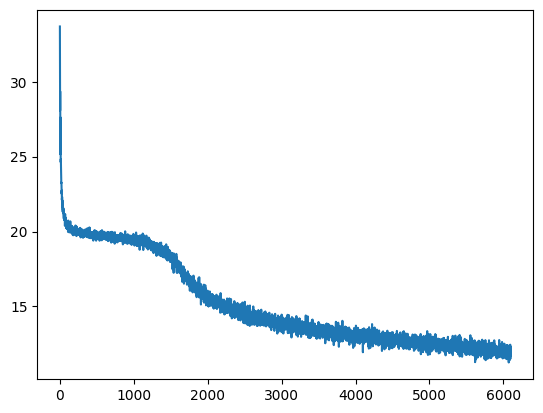

In [36]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [37]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO:"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=1.0
)

print(generated)

ROMEO:
Relingninely reason alike ring.

YORK:
Well, let you bear your rogues in your enemies,
And ere you shall find thy late head:
We presently you are sortful for yourself.

ROMEO:
Lord Warwick, kill a suring sighs again,
Unto my one hands a liars as thou and dooms:
A good cause to love him for the death makes
He will soon sufferance of all all,
Laid his patriap, sadles out to the truth's writ:
Together, you never bear any noble seal,
And with a nobtutes more proneful lables:
Not whom thou dost all resolve Duke of Gloucester's heat?

ROMEO:
Going give me water.

Nurte:
Not to Tyrel, end Perdita, heart thy looks;
Thy greeting preserve sound against all winess it
Thy cloushes, thy joine Richard's way,
For here vain, yet not give us all meeting,
And tapster's royallure, doth say to thy son:
I help she hath patnifice Menry, and for titles,
As is the freeded in the beloved of thee,
It shall, resigns she his from thy tall grathes:
Yet be mounted at Cuesby's note,
But I hand not should shap

In [40]:
torch.save(model, "fuzzy.pth")
